In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cpi
from scipy import stats
import scipy.stats as st
from colour import Color

In [2]:

# https://www.kaggle.com/datasets/yehorkorzh/imdb-top-250-movies
# Import of IMDB top 250 Movies dataset
movie_metadata_path = "../Resources/imdb_top250_movies.csv"
movie_data_complete = pd.read_csv(movie_metadata_path)


# https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv
#Import of The Movies dataset (revenue and budget data)
movie_bulk_data = "../Resources/movies_metadata.csv"
movie_metadata = pd.read_csv(movie_bulk_data, low_memory=False)



In [17]:
# Clean IMDB data to remove unneeded rows
movie_data_clean= movie_data_complete.drop(columns=['Unnamed: 0','imdbID','Metascore','Plot','Actors','DVD','Type','Website','Awards','Writer','Country','Language'])
movie_data_clean['Runtime'] = movie_data_clean['Runtime'].str.replace('min', '')
movie_data_clean['Runtime'] = movie_data_clean['Runtime'].astype(int)

# Copy IMDB Cleaned dataset to merge with revenue/budget data
movie_data_copy = movie_data_clean.copy()

# Reset index so that index # is the same as rating number.
movie_data_clean = movie_data_clean.set_index('Num')
movie_data_clean.head()

,Title,Year,Released,Runtime,Genre,Director,imdbRating,imdbVotes,BoxOffice,Production
Num,,,,,,,,,,
1,The Shawshank Redemption,1994,14-Oct-94,142,"Crime, Drama",Frank Darabont,9.3,"1,825,626",NaN,Columbia Pictures
2,The Godfather,1972,24-Mar-72,175,"Crime, Drama",Francis Ford Coppola,9.2,"1,243,444",NaN,Paramount Pictures
3,The Godfather: Part II,1974,20-Dec-74,202,"Crime, Drama",Francis Ford Coppola,9.0,"856,870",NaN,Paramount Pictures
4,The Dark Knight,2008,18-Jul-08,152,"Action, Crime, Drama",Christopher Nolan,9.0,"1,802,351","$533,316,061",Warner Bros. Pictures/Legendary
5,12 Angry Men,1957,1-Apr-57,96,"Crime, Drama",Sidney Lumet,8.9,"494,215",NaN,Criterion Collection


In [24]:
# Clean Revenue/Budget data for merging
metadata_clean = movie_metadata[["original_title", "revenue", "budget"]]
metadata_clean = metadata_clean.rename(columns={"original_title":"Title", "revenue":"BoxOffice"})
metadata_merge = pd.merge(movie_data_copy, metadata_clean, on="Title")
metadata_merge['budget'] = metadata_merge.loc[:, 'budget'].astype(int)

# Filter out zero value rows from merged dataset
metadata_merge['BoxOffice_y'] = metadata_merge.loc[:, 'BoxOffice_y'].astype(int)
metadata_merge = metadata_merge[metadata_merge["BoxOffice_y"] > 1000]
metadata_merge = metadata_merge[metadata_merge["budget"] > 1000]

# Clean up merged dataset for analysis
# metadata_merge['BoxOffice_y'] = metadata_merge.loc[:, 'BoxOffice_y'].astype(int)
metadata_merge = metadata_merge.rename(columns={"BoxOffice_y":"Revenue","budget":"Budget"})
metadata_merge = metadata_merge.drop(columns=["BoxOffice_x"])
# Correct sort back to index value
metadata_merge.sort_index()
# Reset index to rating number
movie_data_with_revenue = metadata_merge.set_index('Num')
movie_data_with_revenue = movie_data_with_revenue.drop_duplicates(subset=['Title'], keep= 'last')
movie_data_with_revenue.head()


,Title,Year,Released,Runtime,Genre,Director,imdbRating,imdbVotes,Production,Revenue,Budget
Num,,,,,,,,,,,
1,The Shawshank Redemption,1994,14-Oct-94,142,"Crime, Drama",Frank Darabont,9.3,"1,825,626",Columbia Pictures,28341469,25000000
2,The Godfather,1972,24-Mar-72,175,"Crime, Drama",Francis Ford Coppola,9.2,"1,243,444",Paramount Pictures,245066411,6000000
3,The Godfather: Part II,1974,20-Dec-74,202,"Crime, Drama",Francis Ford Coppola,9.0,"856,870",Paramount Pictures,47542841,13000000
4,The Dark Knight,2008,18-Jul-08,152,"Action, Crime, Drama",Christopher Nolan,9.0,"1,802,351",Warner Bros. Pictures/Legendary,1004558444,185000000
5,12 Angry Men,1957,1-Apr-57,96,"Crime, Drama",Sidney Lumet,8.9,"494,215",Criterion Collection,1000000,350000


In [30]:
# Export the revenue data into a csv
movie_data_with_revenue.to_csv("merge.csv", index_label="Title")

In [49]:
#inflation adjustment for Budget and Revenue
# https://towardsdatascience.com/the-easiest-way-to-adjust-your-data-for-inflation-in-python-365490c03969

# movie_data_with_revenue["Revenue (Adjusted for Inflation)"] = movie_data_with_revenue.apply(lambda x: cpi.inflate(x["Revenue"], x["Year"]), axis=1)
movie_data_with_revenue["Budget (Adjusted for Inflation)"] = movie_data_with_revenue.apply(lambda x: cpi.inflate(x["Budget"], x["Year"]), axis=1)
# movie_data_with_revenue["Revenue (Adjusted for Inflation)"] = movie_data_with_revenue.loc[:, "Revenue (Adjusted for Inflation)"].astype(int)
movie_data_with_revenue["Budget (Adjusted for Inflation)"] = movie_data_with_revenue.loc[:, "Budget (Adjusted for Inflation)"].astype(int)

# Eliminate unused columns
movie_data_adjusted = movie_data_with_revenue[["Title", "Year", "Budget (Adjusted for Inflation)", "Revenue"]]

# Filter out obvious outliers
# https://en.wikipedia.org/wiki/List_of_most_expensive_films
movie_data_adjusted = movie_data_adjusted[movie_data_adjusted["Budget (Adjusted for Inflation)"] <= 500000000]
movie_data_adjusted.count()

Title                              211
Year                               211
Budget (Adjusted for Inflation)    211
Revenue                            211
dtype: int64

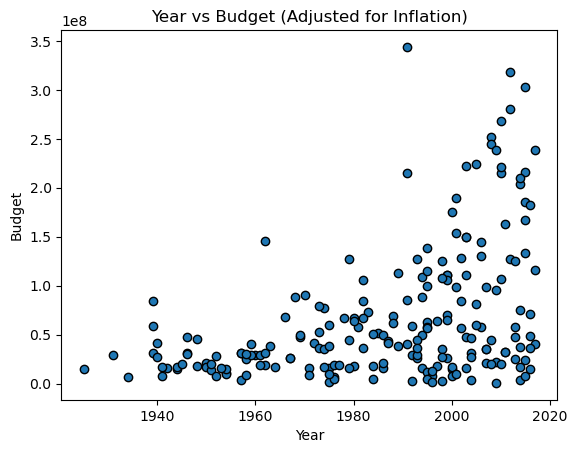

In [50]:
# Release year vs budget (adjusted)
year = movie_data_adjusted["Year"]
budget = movie_data_adjusted["Budget (Adjusted for Inflation)"]

plt.scatter(year, budget, edgecolor ='black')

# # Incorporate the other graph properties
plt.title("Year vs Budget (Adjusted for Inflation)")
plt.xlabel("Year")
plt.ylabel("Budget")

# # Save the figure
# plt.savefig("output_data/Fig2.png")

# Show plot
plt.show()
    
    

In [56]:
movie_data_adjusted.sort_values(by=["Revenue"], ascending=False) 

,Title,Year,Budget (Adjusted for Inflation),Revenue
Num,,,,
170,Star Wars: The Force Awakens,2015,302511950,2068223624
220,The Avengers,2012,280425882,1519557910
169,Harry Potter and the Deathly Hallows: Part 2,2011,162630201,1342000000
197,Beauty and the Beast,1991,343794419,1262886337
7,The Lord of the Rings: The Return of the King,2003,149508532,1118888979
...,...,...,...,...
5,12 Angry Men,1957,3645169,1000000
151,The Maltese Falcon,1941,7465688,1000000
242,The Wild Bunch,1969,49791915,638641


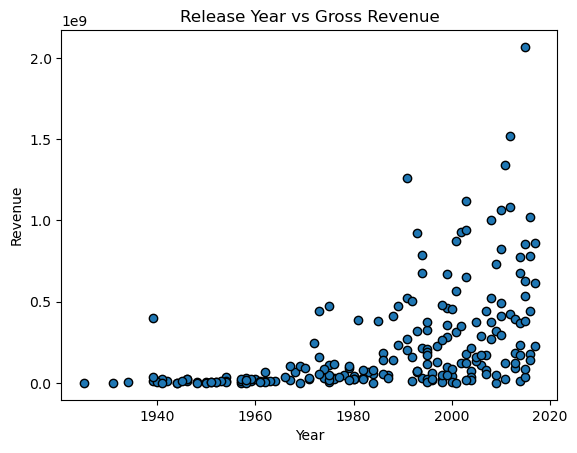

In [55]:
# Release year vs revenue (adjusted)
year = movie_data_adjusted["Year"]
revenue = movie_data_adjusted["Revenue"]

plt.scatter(year, revenue, edgecolor ='black')

# # Incorporate the other graph properties
plt.title("Release Year vs Gross Revenue")
plt.xlabel("Year")
plt.ylabel("Revenue")

# # Save the figure
# plt.savefig("output_data/Fig2.png")

# Show plot
plt.show()